In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021


In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from Modelling import modelling
import matplotlib.pyplot as plt
from DataPrep.ImportData import importer
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyforest
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = importer().Import()

Label: 0.0
Number of diff 1


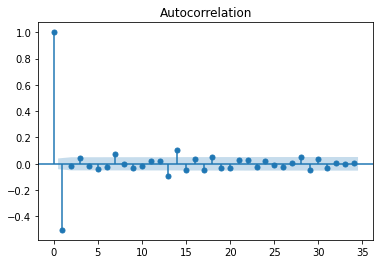

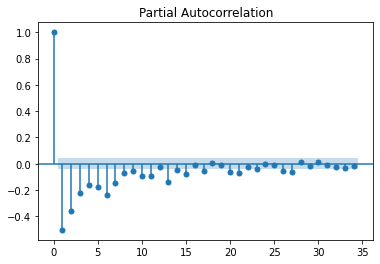

In [71]:
def ArimaStats(df,label):
    print(f"Label: {label}")
    df=df[df["Label"]==label]
    df=df.sort_values("Start Date")
    y = df[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)
    y= y.resample("d").min()
    X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    X_train=X_train.drop(columns="lag_0")
    X_test=X_test.drop(columns="lag_0")
    y_train = y_train.set_index("Start Date",drop=False)
    y_test = y_test.set_index("Start Date",drop=False)
    
    y_train.freq= "D"
    y_train = y_train.resample("d").min()
    y_train  = y_train.fillna(0)
    y_test  = y_test.fillna(0)

    p=1
    for i in range(1,3):
        if p>0.05:
            result = adfuller(y_train["Energy (kWh)"].dropna())
            #print('ADF Statistic: %f' % result[0])
            #print('p-value: %f' % result[1])
            p=result[1]
            if p>0.05:
                y_train["Energy (kWh)"]=y_train["Energy (kWh)"].diff()
                print(f"Number of diff {i}")


    plot_acf(y_train["Energy (kWh)"].dropna())
    plt.show()
    plot_pacf(y_train["Energy (kWh)"].dropna())
    plt.show()
ArimaStats(df,0.0)

Label: 0.0
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


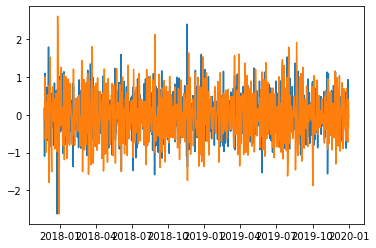

r^2: -0.28753396473853887


<IPython.core.display.Javascript object>

RMSE 0.6545843224008107
MAPE 6.629806624580636
MAE 0.510973181612601


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Smape: 59.991382099427256


In [117]:
def ArimaModels(df,label,ar,d,ma):
    print(f"Label: {label}")
    df=df[df["Label"]==label]
    df=df.sort_values("Start Date")
    y = df[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)
    
    if d>0:
        for i in range(0,d):
            y["Energy (kWh)"] =y["Energy (kWh)"].diff().dropna()  

    #y["Energy (kWh)"] = np.log(y["Energy (kWh)"]) 
    y= y.resample("d").min()
    X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    X_train=X_train.drop(columns="lag_0")
    X_test=X_test.drop(columns="lag_0")
    y_train = y_train.set_index("Start Date",drop=False)
    y_test = y_test.set_index("Start Date",drop=False)

    y_train.freq= "D"
    y_train = y_train.resample("d").min()
    y_test = y_test.resample("d").min()
    y_train["Energy (kWh)"]  = y_train["Energy (kWh)"].fillna(0)
    y_test["Energy (kWh)"]  = y_test["Energy (kWh)"].fillna(0)

    

    sam = SARIMAX((y_train["Energy (kWh)"]),exog=X_train.fillna(0), order=(ar,0,ma), trend="n", freq="D")
    sam_fit = sam.fit(method="lbfgs")
    #print(sam_fit.summary())

    n=len(y_test["Energy (kWh)"])
    y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))
    plt.plot(y_test["Energy (kWh)"])
    plt.plot(y_pred)
    plt.show()


    print("r^2:", r2_score(y_test["Energy (kWh)"],y_pred))
    print("RMSE",np.sqrt(mean_squared_error(y_test["Energy (kWh)"],y_pred))) 
    print("MAPE",mean_absolute_percentage_error(y_test["Energy (kWh)"],y_pred))
    print("MAE",mean_absolute_error(y_test["Energy (kWh)"],y_pred))
    print("Smape:", smape(y_test['Energy (kWh)'],y_pred))
ArimaModels(df,0.0,1,1,7)



In [4]:
def smape(A, F):
    return 100/len(A) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [207]:
def ArimaModels(df):
    res = pd.DataFrame(columns=["Label","ar","d","ma","AIC","r^2","RMSE","MAPE","MAE","SMAPE"])
    for label in range(8):
        print(f"Label: {float(label)}")
        df1=df[df["Label"]==float(label)]
        df1=df1.sort_values("Start Date")
        y = df1[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)

        y= y.resample("d").min()
        X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
        X_train=X_train.drop(columns="lag_0")
        X_test=X_test.drop(columns="lag_0")
        y_train = y_train.set_index("Start Date",drop=False)
        y_test = y_test.set_index("Start Date",drop=False)

        y_train.freq= "D"
        y_train = y_train.resample("d").min()
        y_test = y_test.resample("d").min()
        y_train["Energy (kWh)"]  = y_train["Energy (kWh)"].fillna(0)
        y_test["Energy (kWh)"]  = y_test["Energy (kWh)"].fillna(0)


        
        for ar in range(10):
            for d in range(3):
                for ma in range(10):
                    sam = SARIMAX((y_train["Energy (kWh)"]),exog=X_train.fillna(0), order=(ar,d,ma), trend="n", freq="D")
                    sam_fit = sam.fit(method="lbfgs")
                    n=len(y_test["Energy (kWh)"])
                    y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))

                    AIC = sam_fit.aic
                    r = r2_score(y_test["Energy (kWh)"],y_pred)
                    RMSE = np.sqrt(mean_squared_error(y_test["Energy (kWh)"],y_pred))
                    MAPE = mean_absolute_percentage_error(y_test["Energy (kWh)"],y_pred)
                    MAE = mean_absolute_error(y_test["Energy (kWh)"],y_pred)
                    SMAPE = smape(y_test['Energy (kWh)'],y_pred)
                   
                    results = dict(zip(list(res.columns),[label,ar,d,ma,AIC,r,RMSE,MAPE,MAE,SMAPE]))
                    res = res.append(results,True)
        
    return res
models = ArimaModels(df)

<IPython.core.display.Javascript object>

Label: 0.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 2.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 3.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 4.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 5.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 6.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Label: 7.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [208]:
models

,Label,ar,d,ma,AIC,r^2,RMSE,MAPE,MAE,SMAPE
0,0.0,0.0,0.0,0.0,2525.074997,-0.180721,0.456023,1.502116e-01,0.357991,7.257918
1,0.0,1.0,0.0,0.0,2452.708092,-1.278871,0.633538,2.100055e-01,0.506023,10.282629
2,1.0,0.0,0.0,0.0,4133.346777,-0.118407,0.504682,1.358979e-01,0.390609,6.608715
3,1.0,1.0,0.0,0.0,4008.445440,-1.367476,0.734279,1.989252e-01,0.576416,9.822713
4,2.0,0.0,0.0,0.0,2172.864386,-0.094798,0.437430,1.268175e-01,0.339346,6.216752
5,2.0,1.0,0.0,0.0,2101.788540,-0.777499,0.557374,1.584233e-01,0.429072,7.841099
6,3.0,0.0,0.0,0.0,3575.357538,-0.165434,1.070719,5.356007e+13,0.807520,9.084027
7,3.0,1.0,0.0,0.0,3544.671577,-1.042457,1.417451,7.126280e+13,1.070696,11.989282
8,4.0,0.0,0.0,0.0,2238.651752,-0.112068,0.788024,2.362797e+13,0.635646,12.597723
9,4.0,1.0,0.0,0.0,2173.091356,-1.068935,1.074848,4.092430e+13,0.847443,17.222222


In [6]:
df=df[df["Label"]==6.0]
df=df.sort_values("Start Date")

In [44]:
#X = df[['Energy (kWh)_lag1', 'Energy (kWh)_lag2',
#       'Energy (kWh)_lag3', 'Energy (kWh)_lag4', 'Energy (kWh)_lag5']]
#X = df["Charging Time (mins)"]
y = df[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)
y= y.resample("d").min()
X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [45]:
X_train=X_train.drop(columns="lag_0")
X_test=X_test.drop(columns="lag_0")

In [31]:
y_train = y_train.set_index("Start Date",drop=False)
y_test = y_test.set_index("Start Date",drop=False)

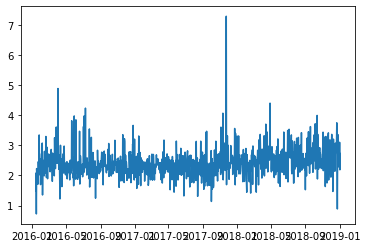

In [47]:
plt.plot(y_train["Energy (kWh)"])
plt.show()

In [48]:
result = adfuller(y_train["Energy (kWh)"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.173110
p-value: 0.000731


In [14]:
#y_test = y_test.diff().dropna()
#y_train = y_train.diff().dropna()

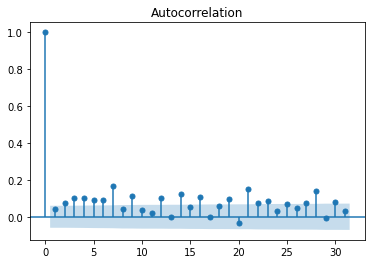

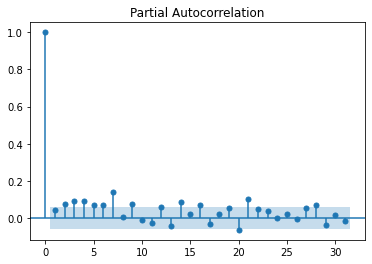

In [18]:
plot_acf(y_train["Energy (kWh)"].dropna())
plt.show()
plot_pacf(y_train["Energy (kWh)"].dropna())
plt.show()

In [35]:
y_train.freq= "D"
y_train = y_train.resample("d").min()
y_test  = y_test.fillna(0)

In [297]:
sam = SARIMAX((y_train["Energy (kWh)"]),exog=X_train.fillna(0), order=(5,0,5), seasonal_order=(5,0,4,7), trend="n", freq="D")

ValueError: Models with time-varying regression coefficients must integrate the coefficients as part of the state vector, so that `mle_regression` must be set to False.

In [291]:
sam_fit = sam.fit(method="lbfgs")

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [292]:
sam_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                 Energy (kWh)   No. Observations:                 1086
Model:             SARIMAX(5, 0, 5)x(5, 0, [1, 2, 3, 4], 7)   Log Likelihood                -718.202
Date:                                      Wed, 24 Mar 2021   AIC                           1486.403
Time:                                              16:56:10   BIC                           1611.160
Sample:                                          01-14-2016   HQIC                          1533.629
                                               - 01-03-2019                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          0.7500      0.147      5.089      0.000       0.461       1.039
lag_2          0.1659      0.153      1.087      0.277      -0.133       0.465
lag_3         -0.0227      0.104     -0.218      0.827      -0.226       0.181
lag_4         -0.0016      0.074     -0.022      0.982      -0.147       0.144
lag_5          0.1084      0.063      1.728      0.084      -0.015       0.231
ar.L1         -0.3326      0.204     -1.626      0.104      -0.733       0.068
ar.L2         -0.4469      0.214     -2.088      0.037      -0.867      -0.027
ar.L3          0.1571      0.178      0.884      0.377      -0.191       0.506
ar.L4         -0.4105      0.176     -2.334      0.020      -0.755      -0.066
ar.L5          0.2732      0.096      2.834      0.005       0.084       0.462
ma.L1         -0.3384      0.199     -1.703      0.089      -0.728       0.051
ma.L2          0.0668      0.146      0.457      0.648      -0.220       0.353
ma.L3         -0.4219      0.117     -3.618      0.000      -0.650      -0.193
ma.L4          0.4878      0.175      2.785      0.005       0.145       0.831
ma.L5         -0.5941      0.125     -4.742      0.000      -0.840      -0.349
ar.S.L7        0.1811      0.820      0.221      0.825      -1.425       1.788
ar.S.L14       0.0131      0.621      0.021      0.983      -1.204       1.230
ar.S.L21       0.2701      0.686      0.394      0.694      -1.074       1.615
ar.S.L28       0.2800      0.816      0.343      0.732      -1.319       1.879
ar.S.L35       0.0173      0.082      0.211      0.833      -0.143       0.177
ma.S.L7       -0.0476      0.816     -0.058      0.953      -1.646       1.551
ma.S.L14       0.0362      0.614      0.059      0.953      -1.167       1.239
ma.S.L21      -0.2179      0.635     -0.343      0.731      -1.462       1.026
ma.S.L28      -0.2837      0.737     -0.385      0.700      -1.728       1.161
sigma2         0.2177      0.006     38.525      0.000       0.207       0.229
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              6555.53
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             1.14
Prob(H) (two-sided):                  0.70   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

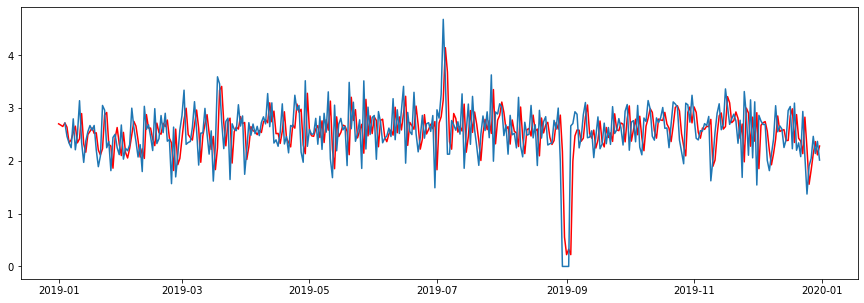

In [293]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(sam_fit.predict(start=pd.to_datetime("2019-01-01"),end=pd.to_datetime("2019-12-31"), dynamic=False,typ="levels", exog=X_test.fillna(0)),c="r")
#plt.plot(y_test["Energy (kWh)"])
plt.plot(y_test["Energy (kWh)"])
#plt.figure(figsize=(15, 3))
plt.show()

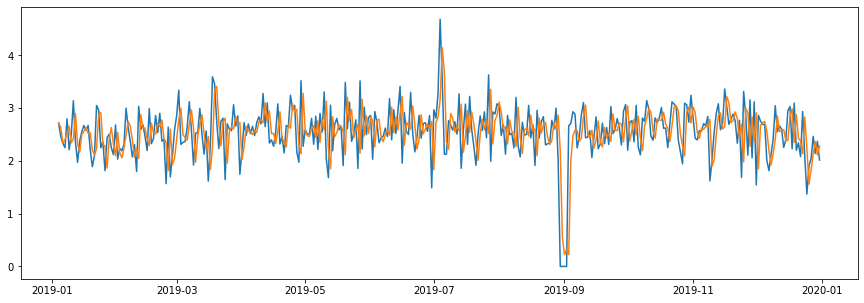

In [294]:
n=362
y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))
plt.plot(y_test["Energy (kWh)"])
plt.plot(y_pred)
plt.show()

In [296]:
print("r^2:", r2_score(y_test["Energy (kWh)"],y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test["Energy (kWh)"],y_pred))) 

r^2: -0.17435456397476035


<IPython.core.display.Javascript object>

RMSE 0.5373288360181832
